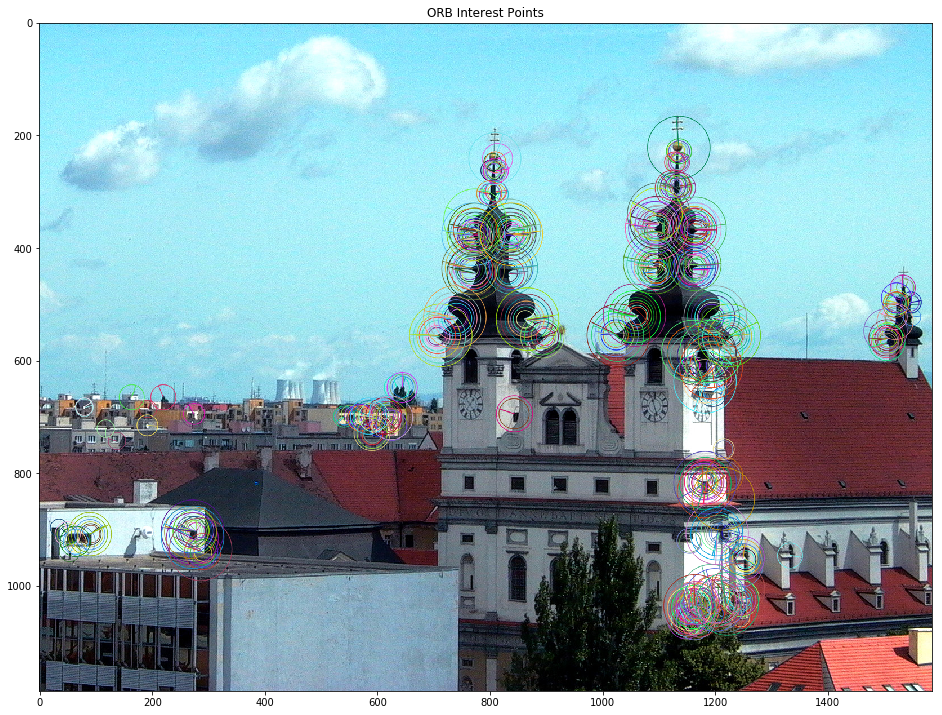

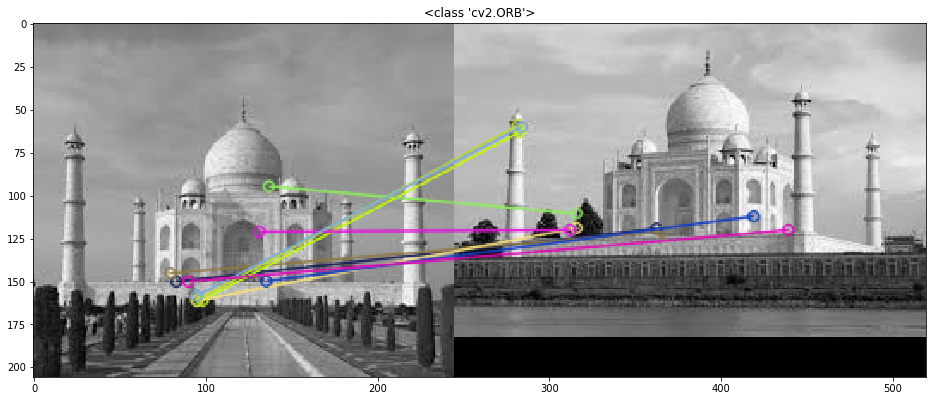

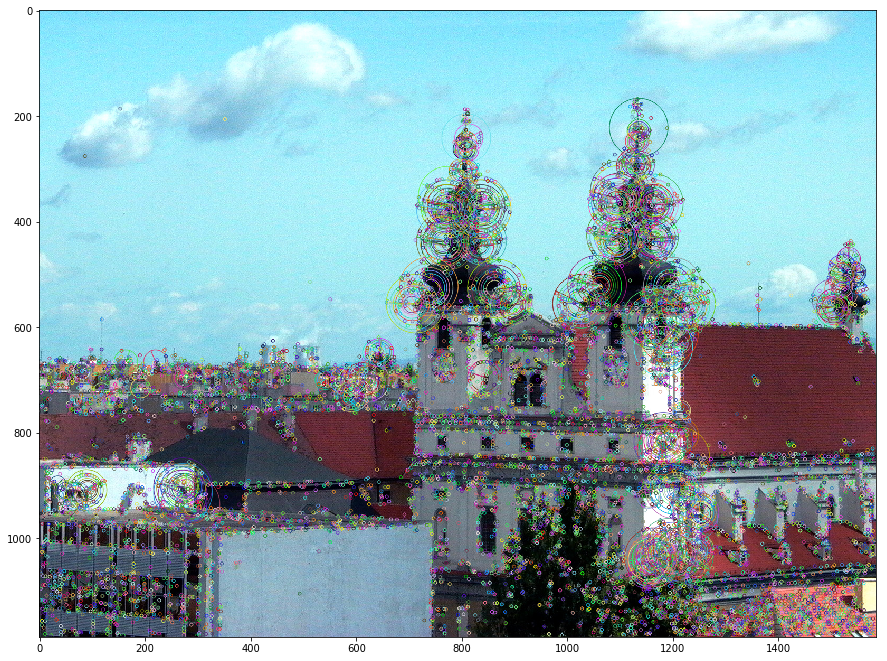

In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import os

%matplotlib inline






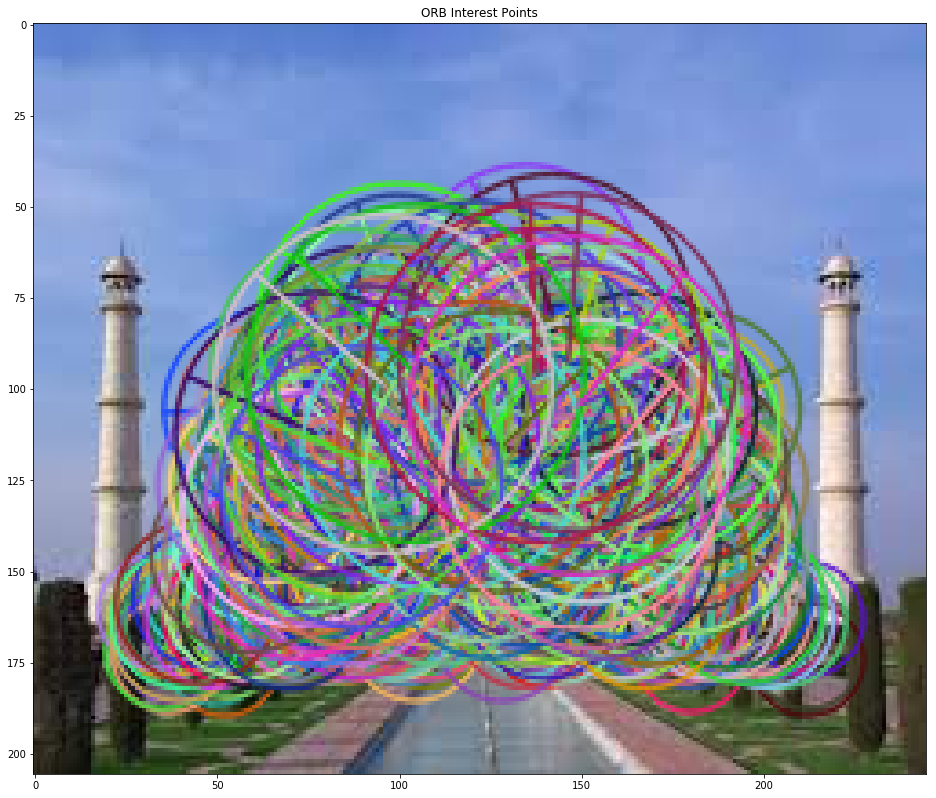

In [2]:
#dataset_path = '../input/google-image-recognition-tutorial'
img_building = cv2.imread('building3.jpg')
img_building = cv2.cvtColor(img_building, cv2.COLOR_BGR2RGB)  # Convert from cv's BRG default color order to RGB

orb = cv2.ORB_create()  # OpenCV 3 backward incompatibility: Do not create a detector with `cv2.ORB()`.
key_points, description = orb.detectAndCompute(img_building, None)
img_building_keypoints = cv2.drawKeypoints(img_building, 
                                           key_points, 
                                           img_building, 
                                           flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS) # Draw circles.
plt.figure(figsize=(16, 16))
plt.title('ORB Interest Points')
plt.imshow(img_building_keypoints); plt.show()

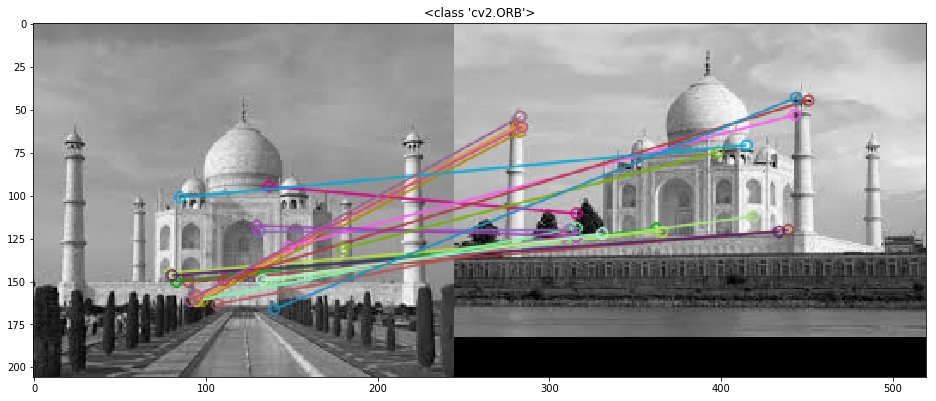

In [7]:
def image_detect_and_compute(detector, img_name):
    """Detect and compute interest points and their descriptors."""
    img = cv2.imread(img_name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    kp, des = detector.detectAndCompute(img, None)
    return img, kp, des
    

def draw_image_matches(detector, img1_name, img2_name, nmatches=20):
    """Draw ORB feature matches of the given two images."""
    img1, kp1, des1 = image_detect_and_compute(detector, img1_name)
    img2, kp2, des2 = image_detect_and_compute(detector, img2_name)
    
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1, des2)
    matches = sorted(matches, key = lambda x: x.distance) # Sort matches by distance.  Best come first.
    
    img_matches = cv2.drawMatches(img1, kp1, img2, kp2, matches[:nmatches], img2, flags=2) # Show top 10 matches
    plt.figure(figsize=(16, 16))
    plt.title(type(detector))
    plt.imshow(img_matches); plt.show()
    

orb = cv2.ORB_create()
draw_image_matches(orb, 'building3.jpg', 'buliding3_1.jpg')


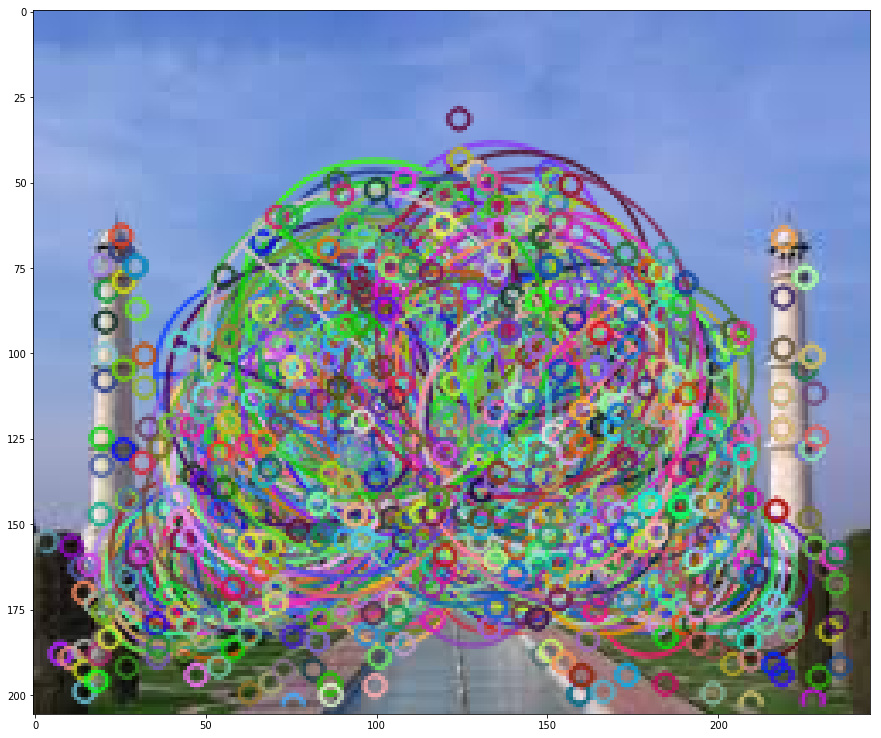

In [4]:
sift = cv2.xfeatures2d.SIFT_create()
kp, des = sift.detectAndCompute(img_building, None)
img_kp = cv2.drawKeypoints(img_building, kp, img_building)

plt.figure(figsize=(15, 15))
plt.imshow(img_kp); plt.show()

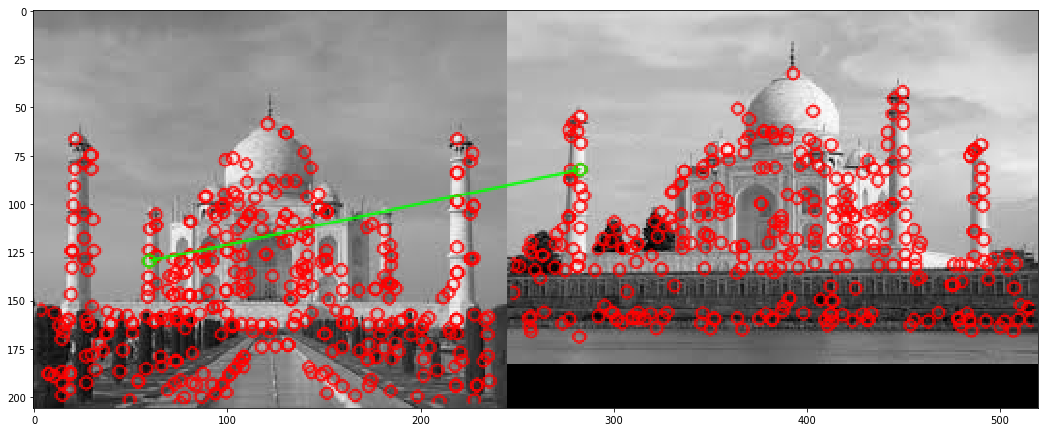

In [6]:
img1, kp1, des1 = image_detect_and_compute(sift, 'building3.jpg')
img2, kp2, des2 = image_detect_and_compute(sift, 'buliding3_1.jpg')

FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)

flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1, des2, k=2)

matchesMask = [[0, 0] for i in range(len(matches))]
# ratio test as per Lowe's paper
for i, (m, n) in enumerate(matches):
    if m.distance < 0.55*n.distance:
        matchesMask[i] = [1, 0]

draw_params = dict(matchColor=(0, 255, 0),
                   singlePointColor=(255, 0, 0),
                   matchesMask=matchesMask,
                   flags=0)

img3 = cv2.drawMatchesKnn(img1, kp1, img2, kp2, matches, None, **draw_params)
plt.figure(figsize=(18, 18))
plt.imshow(img3); plt.show()

In [10]:


MIN_MATCH_COUNT = 10

img1 = cv2.imread('img1.jpg',0)          # queryImage
img2 = cv2.imread('img2.jpg',0) # trainImage

# Initiate SIFT detector

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)

flann = cv2.FlannBasedMatcher(index_params, search_params)

matches = flann.knnMatch(des1,des2,k=2)

# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)

In [12]:
if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()

    h,w = img1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)

    img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)

else:
    print("Not enough matches are found - %d/%d" % (len(good),MIN_MATCH_COUNT))
    matchesMask = None

Not enough matches are found - 4/10


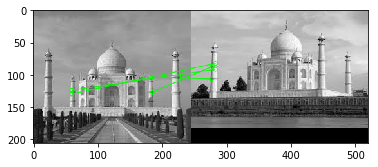

(<matplotlib.image.AxesImage at 0x2565102efd0>, None)

In [13]:
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)

img3 = cv2.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)

plt.imshow(img3, 'gray'),plt.show()